In [1]:
#Link to dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
#Paper describing the original data collection: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0119491#sec002

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
raw_data = pd.read_excel('Data_Cortex_Nuclear.xls')
#raw_data.info()

In [4]:
# Most column names are protein names; the ones that aren't are MouseID, class, Genotype, Treatment, and Behavior.    
# class summarizes Genotype, Treatment, and Behavior
# MouseID includes both mouse ID and measurement number (15 measurements/mouse).
# Separate the Mouse ID from the measurement replicate:
new_cols = ['Mouse','Rep']
data = raw_data.join(pd.DataFrame(list(raw_data['MouseID'].str.split('_')),columns = new_cols))
data.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class,Mouse,Rep
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m,309,1
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m,309,2
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m,309,3
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m,309,4
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m,309,5


In [25]:
# identify which columns represent protein names
not_a_protein = ['Genotype','Behavior','Treatment','class'] + new_cols + ['MouseID']
protein_names = list(set(data.columns.values) - set(not_a_protein)) 
#Note this protein_names list will not be in the same order as the original columns

In [10]:
#Looks like missing values are either (1) a mouse has no measurements for certain proteins or (2) a certain mouse is missing a subset of measuremne
missing_value_counts = data.set_index(not_a_protein).isnull().groupby(['class','Mouse']).sum()
missing_value_counts_subset = missing_value_counts.loc[missing_value_counts.sum(axis=1)!=0,missing_value_counts.sum(axis=0)!=0]
#missing_value_counts_subset.info()
#36 mice and 49 proteins are missing at least some data

In [7]:
# Check to see how many data points are outliers within a particular Mouse x protein
# preliminarily define outlier as 3 SDs outside the mean.  With a normal distribution, that will only be 0.3% of data points
# this is <1 point per Mouse x protein, but 2455 total. (data[protein_names].count(axis=0).sum() * 0.03)
outlier_sds = 3
means = data.groupby('Mouse').mean()[protein_names]
sds = data.groupby('Mouse').std()[protein_names]
mice = data['Mouse'].unique()
outliers_count = pd.DataFrame(columns=means.columns, index=means.index)
for mouse in mice:
    for protein in protein_names:
        is_outlier = abs(data.loc[data.Mouse == mouse,protein]-means.loc[mouse,protein]) > outlier_sds * sds.loc[mouse,protein]
        outliers_count.loc[mouse,protein] = is_outlier.sum()
outliers_count.sum().sum()

70

In [53]:
# Example of mouse/protein with outlier data
mouse = '3520'
protein = 'RRP1_N'
data.loc[data.Mouse == mouse,protein]

120    0.150522
121    0.157563
122    0.155561
123    0.149880
124    0.152557
125    0.153254
126    0.150593
127    0.148813
128    0.149689
129    0.142723
130    0.146593
131    0.146439
132    0.134029
133    0.391480
134    0.154156
Name: RRP1_N, dtype: float64

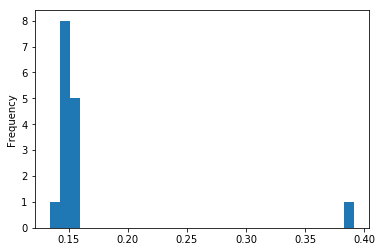

In [57]:
data.loc[data.Mouse == mouse,protein].plot(kind='hist',bins=30)

In [54]:
# Replace outlier technical replicates with NaN; 
# I don't believe the data is big enough to justify discarding apparent outlier biological replicates
outliers = data.copy()
data_clean = data.copy()
for protein in protein_names: 
    for mouse in mice:
        is_outlier = abs(data.loc[data.Mouse == mouse,protein]-means.loc[mouse,protein]) > outlier_sds * sds.loc[mouse,protein]
        outliers.loc[data.Mouse == mouse,protein] = is_outlier
    data_clean.loc[outliers.loc[:,protein],protein] = None

In [55]:
#Spot check outlier removal
mouse = '3520'
protein = 'RRP1_N'
data_clean.loc[data_clean.Mouse == mouse,protein]

120    0.150522
121    0.157563
122    0.155561
123    0.149880
124    0.152557
125    0.153254
126    0.150593
127    0.148813
128    0.149689
129    0.142723
130    0.146593
131    0.146439
132    0.134029
133         NaN
134    0.154156
Name: RRP1_N, dtype: float64

In [58]:
# Now collapse the technical replicates into means and standard deviations
# and reindex so that only dependent variables are in columns
new_index = ['Genotype','Behavior','Treatment','class','Mouse']
means_clean = data_clean.groupby(new_index).mean()
sds_clean = data_clean.groupby(new_index).std()
means_clean.head(15)

DYRK1A_N   ITSN1_N    BDNF_N  \
Genotype Behavior Treatment class  Mouse                                 
Control  C/S      Memantine c-CS-m 309    0.421063  0.576510  0.356447   
                                   311    0.600591  0.678479  0.334548   
                                   320    0.547676  0.796012  0.398649   
                                   321    0.438728  0.652045  0.359441   
                                   322    0.358931  0.512223  0.315105   
                                   3415   0.497119  0.656343  0.314838   
                                   3499   0.319708  0.485349  0.288157   
                                   3507   0.373571  0.539847  0.317287   
                                   3520   0.618710  0.803561  0.341402   
                                   3521   0.628468  0.825504  0.366300   
                  Saline    c-CS-s 3477   0.488180  0.688249  0.382463   
                                   3478   0.372404  0.576646  0.358708   
                                   3479   0.462260  0.628086  0.342307   
                                   3480   0.310680  0.497878  0.310940   
                                   3484   2.036804  2.102645  0.391755   

                                             NR1_N    NR2A_N    pAKT_N  \
Genotype Behavior Treatment class  Mouse                                 
Control  C/S      Memantine c-CS-m 309    2.278252  4.354744  0.219549   
                                   311    2.277561  4.234706  0.227820   
                                   320    2.664515  5.498960  0.241391   
                                   321    2.686405  5.298355  0.231876   
                                   322    2.111664  4.231444  0.232415   
                                   3415   2.366336  4.139486  0.212674   
                                   3499   2.176302  3.350919  0.194603   
                                   3507   2.318377  3.992429  0.233426   
                                   3520   2.522965  3.863553  0.261868   
                                   3521   2.415113  4.120808  0.243697   
                  Saline    c-CS-s 3477   2.347300  4.572360  0.291590   
                                   3478   2.421006  4.231455  0.236329   
                                   3479   2.416516  3.994724  0.154480   
                                   3480   2.282134  3.981532  0.145822   
                                   3484   2.753300  5.207742  0.210738   

                                           pBRAF_N  pCAMKII_N   pCREB_N  \
Genotype Behavior Treatment class  Mouse                                  
Control  C/S      Memantine c-CS-m 309    0.182195   1.922373  0.196064   
                                   311    0.184262   1.931669  0.176511   
                                   320    0.194097   2.406303  0.218364   
                                   321    0.184874   2.502274  0.199109   
                                   322    0.183995   3.574599  0.182309   
                                   3415   0.165161   3.379866  0.179236   
                                   3499   0.152684   3.088278  0.177566   
                                   3507   0.184312   2.141755  0.215901   
                                   3520   0.197174   3.505510  0.216023   
                                   3521   0.193358   4.709240  0.223758   
                  Saline    c-CS-s 3477   0.204403   4.172041  0.239757   
                                   3478   0.180610   2.911131  0.196408   
                                   3479   0.125733   2.690921  0.203513   
                                   3480   0.125910   2.938694  0.168944   
                                   3484   0.179214   2.733639  0.215424   

                                            pELK_N  ...     SHH_N     BAD_N  \
Genotype Behavior Treatment class  Mouse            ...                       
Control  C/S      Memantine c-CS-m 309    1.422933  ...  0.192871  0.151524   
           

In [59]:
#Save this data for later
means_clean.to_csv('Data_Cortex_Nuclear_Means_Clean.csv')
sds_clean.to_csv('Data_Cortex_Nuclear_SDs_Clean.csv')

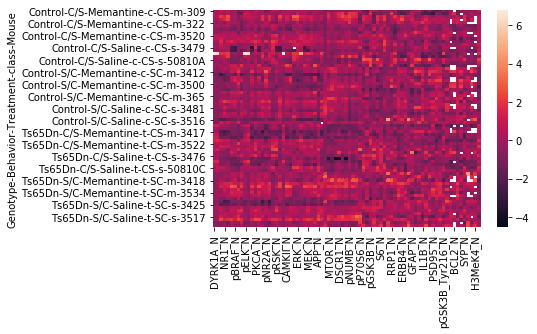

In [60]:
means_scaled = (means_clean - means_clean.mean())/means_clean.std()
sns.heatmap(means_scaled)

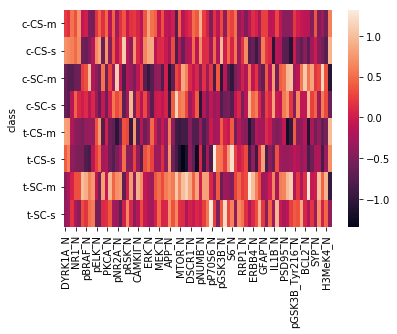

In [61]:
sns.heatmap(means_scaled.groupby('class').mean())

69

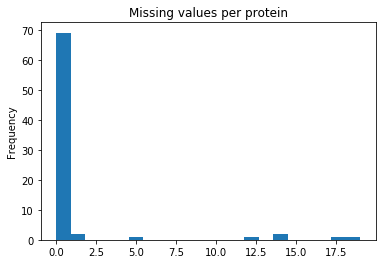

In [76]:
means_clean.isnull().sum().plot(kind='hist',bins=21,title='Missing values per protein')
#how many proteins have no missing values?
(means_clean.isnull().sum()==0).sum()

In [63]:
means_clean.isnull().sum().sum()

84

In [67]:
count_nulls = means_clean.isnull().sum()
count_nulls[count_nulls>0]

ELK_N          1
Bcatenin_N     1
BAD_N         14
BCL2_N        19
pCFOS_N        5
H3AcK18_N     12
EGR1_N        14
H3MeK4_N      18
dtype: int64

In [70]:
means_clean.isnull().loc[:,count_nulls>0].groupby('class').sum()

,ELK_N,Bcatenin_N,BAD_N,BCL2_N,pCFOS_N,H3AcK18_N,EGR1_N,H3MeK4_N
class,,,,,,,,
c-CS-m,0.0,0.0,2.0,2.0,2.0,2.0,2.0,4.0
c-CS-s,1.0,0.0,3.0,2.0,0.0,2.0,2.0,3.0
c-SC-m,0.0,0.0,3.0,5.0,0.0,2.0,3.0,4.0
c-SC-s,0.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0
t-CS-m,0.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0
t-CS-s,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
t-SC-m,0.0,0.0,3.0,3.0,0.0,4.0,2.0,3.0
t-SC-s,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0


In [72]:
means_clean.groupby('class').count().max(axis=1)

class
c-CS-m    10
c-CS-s     9
c-SC-m    10
c-SC-s     9
t-CS-m     9
t-CS-s     7
t-SC-m     9
t-SC-s     9
dtype: int64

In [73]:
means_clean.groupby('class').count().min(axis=1)

class
c-CS-m    6
c-CS-s    6
c-SC-m    5
c-SC-s    7
t-CS-m    7
t-CS-s    6
t-SC-m    5
t-SC-s    6
dtype: int64